# 데이터 불러오기 및 확인

- 2016-06-01 ~ 2019-02-28 카드 거래 데이터를 바탕으로 2019-03-01 ~ 2019-05-31의 3개월 매출을 예상
- data download : https://dacon.io/competitions/official/140472/data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# df의 시간 범위: 2016-06-01 ~ 2019-02-28
df = pd.read_csv('../../data/funda_train.csv')
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [3]:
# submission_df의 범위: 2019-03-01 ~ 2019-05-31
submission_df = pd.read_csv('../../data/submission.csv')
submission_df.head()

,store_id,amount
0,0,0
1,1,0
2,2,0
3,4,0
4,5,0


- store 데이터와 예측의 데이터가 일치하는지 확인

In [4]:
len(df['store_id'].unique())

1967

In [5]:
# df와 submission_df의 일치하는 id / id 전체 길이 = 1 -> 일치
(df['store_id'].unique() == submission_df['store_id'].unique()).sum() / len(submission_df['store_id'].unique())

1.0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [7]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   store_id  1967 non-null   int64
 1   amount    1967 non-null   int64
dtypes: int64(2)
memory usage: 30.9 KB


- df 는 날짜/일시 별 거래 데이터 -> 예측은 store별 3개월 매출 예측
- ...t-2, t-1, t 의 데이터를 바탕으로 3개월 t+1, t+2, t+3을 예측
- 상점별로 / 월별로 내역을 요약하여 새로운 데이터로 정의

# 학습 데이터 구축
- 현재 데이터는 상점별/날짜별의 낱개 샘플들의 데이터
- 학습 데이터, 즉 월별(3개월) 매출 데이터의 예측을 위한 머신러닝 모델링을 위해 알맞는 학습 데이터 형식으로 만들어야 한다.
- raw data를 가지고 탐색하며 학습 데이터를 만들 특성들을 탐색하고 만든다.

## 시점 생성 : 년/월 기준

In [8]:
df.columns

Index(['store_id', 'card_id', 'card_company', 'transacted_date',
       'transacted_time', 'installment_term', 'region', 'type_of_business',
       'amount'],
      dtype='object')

- 일자를 년/월로 분할

In [9]:
# .str.split을 이용한 년/월 추출
df['transacted_year'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 0].astype(int)
df['transacted_month'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 1].astype(int)
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,transacted_year,transacted_month
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016,6
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016,6
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016,6
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016,6
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016,6


- 33개월의 데이터로 3개월의 상점별 데이터를 예측해야 할 것이라 본다.

In [10]:
print(len(df.groupby(['transacted_year', 'transacted_month']).count()))
df.groupby(['transacted_year', 'transacted_month']).count()

33


store_id  card_id  card_company  \
transacted_year transacted_month                                    
2016            6                   138617   138617        138617   
                7                   143574   143574        143574   
                8                   146150   146150        146150   
                9                   147418   147418        147418   
                10                  162699   162699        162699   
                11                  159917   159917        159917   
                12                  170036   170036        170036   
2017            1                   158423   158423        158423   
                2                   160970   160970        160970   
                3                   199918   199918        199918   
                4                   213007   213007        213007   
                5                   235747   235747        235747   
                6                   233487   233487        233487   
                7                   235263   235263        235263   
                8                   228899   228899        228899   
                9                   236416   236416        236416   
                10                  216891   216891        216891   
                11                  214984   214984        214984   
                12                  219786   219786        219786   
2018            1                   198286   198286        198286   
                2                   181981   181981        181981   
                3                   225192   225192        225192   
                4                   223168   223168        223168   
                5                   235380   235380        235380   
                6                   224308   224308        224308   
                7                   221135   221135        221135   
                8                   212916   212916        212916   
                9                   211620   211620        211620   
                10                  216553   216553        216553   
                11                  209951   209951        209951   
                12                  206294   206294        206294   
2019            1                   194513   194513        194513   
                2                   173114   173114        173114   

                                  transacted_date  transacted_time  \
transacted_year transacted_month                                     
2016            6                          138617           138617   
                7                          143574           143574   
                8                          146150           146150   
                9                          147418           147418   
                10                         162699           162699   
                11                         159917           159917   
                12                         170036           170036   
2017            1                          158423           158423   
                2                          160970           160970   
                3                          199918           199918   
                4                          213007           213007   
                5                          235747           235747   
                6                          233487           233487   
                7                          235263           235263   
                8                          228899           228899   
                9                          236416           236416   
                10                         216891           216891   
                11                         214984           214984   
                12                         219786           219786   
2018            1                          198286           198286   
                2                          181981           181981   
        

In [11]:
df['t'] = (df['transacted_year'] - 2016) * 12 + df['transacted_month']
df.tail()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,transacted_year,transacted_month,t
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000,2019,2,38
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143,2019,2,38
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000,2019,2,38
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571,2019,2,38
6556612,2136,4658616,c,2019-02-28,23:54,0,제주 제주시,기타 주점업,5857.142857,2019,2,38


## 범주 변수 탐색

### 불필요한 특징(컬럼) 삭제

- 년과 월의 컬럼을 생성 후, 필요없는 날짜에 대한 컬럼은 삭제한다.

In [12]:
df.drop(['transacted_year', 'transacted_month', 'transacted_date', 'transacted_time'], axis = 1, inplace = True)
df.head()

,store_id,card_id,card_company,installment_term,region,type_of_business,amount,t
0,0,0,b,0,NaN,기타 미용업,1857.142857,6
1,0,1,h,0,NaN,기타 미용업,857.142857,6
2,0,2,c,0,NaN,기타 미용업,2000.000000,6
3,0,3,a,0,NaN,기타 미용업,7857.142857,6
4,0,4,c,0,NaN,기타 미용업,2000.000000,6


- card_id, card_company는 특징으로 사용하기에는 너무 세분화될 수 있을 뿐만 아니라, 특징으로 유효할 가능성이 없다고 판단하여 삭제

In [13]:
df.drop(['card_id', 'card_company'], axis = 1, inplace = True)
df.head()

,store_id,installment_term,region,type_of_business,amount,t
0,0,0,NaN,기타 미용업,1857.142857,6
1,0,0,NaN,기타 미용업,857.142857,6
2,0,0,NaN,기타 미용업,2000.000000,6
3,0,0,NaN,기타 미용업,7857.142857,6
4,0,0,NaN,기타 미용업,2000.000000,6


### 특징 파악
    - 할부
    - 지역
    - 업종

- 할부

In [14]:
df['installment_term'].unique()

array([ 0,  2,  3, 60,  4,  5,  6, 10, 12, 15,  7,  8,  9, 18, 24, 16, 14,
       11, 20, 36, 13, 35, 80, 17, 19, 23, 30, 22, 83, 63, 93, 65, 82, 72],
      dtype=int64)

In [15]:
# 대부분이 일시불 : 0
df['installment_term'].value_counts()

0     6327632
3      134709
2       42101
5       23751
6       10792
10       6241
4        4816
12       2699
60       1290
7         553
8         413
24        404
9         349
18        332
15        130
20        116
80         83
11         47
30         43
36         36
16         23
14         12
63          8
83          6
65          6
19          4
72          4
13          3
35          2
23          2
93          2
82          2
17          1
22          1
Name: installment_term, dtype: int64

In [16]:
# 일시불은 그대로 0, 할부는 모두 1로 변환
df['installment_term'] = (df['installment_term'] > 0).astype(int)

# 클래스(범주) 확인 : 클래스 불균형 존재
df['installment_term'].value_counts()

0    6327632
1     228981
Name: installment_term, dtype: int64

In [17]:
# 상점별 할부 상황
installment_term_per_store = df.groupby('store_id')['installment_term'].mean()
installment_term_per_store

store_id
0       0.038384
1       0.000000
2       0.083904
4       0.001201
5       0.075077
          ...   
2132    0.001389
2133    0.014916
2134    0.002261
2135    0.001554
2136    0.001226
Name: installment_term, Length: 1967, dtype: float64

- 지역

In [18]:
len(df['region'].unique())

181

In [19]:
df['region'].unique()

array([nan, '서울 종로구', '충북 충주시', '부산 동래구', '경기 평택시', '부산 동구', '광주 동구',
       '경기 파주시', '대구 수성구', '경기 용인시', '서울 중구', '경기 안양시', '경기 수원시',
       '경기 화성시', '서울 송파구', '서울 마포구', '부산 부산진구', '서울 용산구', '충남 금산군',
       '서울 중랑구', '전남 목포시', '경기 안성시', '서울 영등포구', '서울 동작구', '경기 과천시',
       '경북 경주시', '인천 계양구', '서울 강서구', '경기 성남시', '인천 남동구', '서울 광진구',
       '서울 서대문구', '서울 은평구', '서울 강남구', '강원 강릉시', '서울 구로구', '서울 서초구',
       '경기 시흥시', '인천 서구', '서울 양천구', '경기 부천시', '경기 광주시', '서울 금천구',
       '서울 관악구', '인천 남구', '인천 동구', '충북 제천시', '광주 광산구', '인천 연수구', '인천 부평구',
       '경기 의왕시', '전남 순천시', '경기 이천시', '경기 의정부시', '경기 포천시', '경기 양주시',
       '경기 고양시', '충북 옥천군', '경기 광명시', '경기 구리시', '경기 남양주시', '경기 가평군',
       '전남 여수시', '경기 안산시', '경기 오산시', '경기 김포시', '서울 성동구', '전북 군산시',
       '경남 김해시', '경기 군포시', '제주 서귀포시', '서울 강북구', '제주 제주시', '부산 금정구',
       '경북 구미시', '광주 서구', '부산 사상구', '충남 천안시', '강원 원주시', '충남 아산시',
       '경북 포항시', '부산 강서구', '강원 횡성군', '대구 남구', '경남 양산시', '경남 창원시',
       '강원 양구군', '경남 통영시', '충남 당진시', '부산 사하구', '강

In [20]:
# groupby에 결측을 포함시키기 위해, 결측을 문자로 대체
# 지역은 너무 많아서 그대로 활용하기 어려움. 따라서 그대로 더미화하지 않고, 이를 기반으로 한 새로운 변수를 파생해서 사용
df['region'].fillna('없음', inplace = True)
df['region'].value_counts().head()

없음        2042766
경기 수원시     122029
충북 청주시     116766
경남 창원시     107147
경남 김해시     100673
Name: region, dtype: int64

- 업종

In [21]:
len(df['type_of_business'].unique())

146

In [22]:
df['type_of_business'].unique()

array(['기타 미용업', nan, '의복 액세서리 및 모조 장신구 도매업', '한식 음식점업',
       '배관 및 냉ㆍ난방장치 도매업', '그 외 기타 스포츠시설 운영업', '간이음식 포장 판매 전문점',
       '안경 및 렌즈 소매업', '그 외 기타 분류 안된 상품 전문 소매업', '채소, 과실 및 뿌리작물 소매업',
       '서양식 음식점업', '통신기기 소매업', '기타 주점업', '의복 소매업', '두발 미용업',
       '섬유, 직물 및 의복액세서리 소매업', '외국어학원', '기타 외국식 음식점업', '가정용 세탁업',
       '낚시장 운영업', '육류 소매업', '전자상거래 소매업', '일식 음식점업', '화장품, 비누 및 방향제 소매업',
       '가전제품 소매업', '기타 스포츠 교육기관', '체형 등 기타 신체관리 서비스업', '여행사업',
       '기타 교육지원 서비스업', '기타 교습학원', '곡물 및 기타 식량작물 재배업', '기록매체 복제업',
       '골프연습장 운영업', '속옷 및 잠옷 소매업', '그 외 기타 분류 안된 사업지원 서비스업', '담배 소매업',
       '기타 예술학원', '문구용품 및 회화용품 소매업', '기타 음ㆍ식료품 위주 종합 소매업',
       '운동 및 경기용품 소매업', '그 외 기타 상품 전문 도매업', '그 외 기타 창작 및 예술관련 서비스업',
       '자전거 및 기타 운송장비 소매업', '가구 소매업', '애완용 동물 및 관련용품 소매업',
       '철물, 금속 파스너 및 수공구 도매업', '피부 미용업', '기타 자동차 신품 부품 및 내장품 판매업',
       '비알코올 음료점업', '화장품 및 화장용품 도매업', '애완동물 장묘 및 보호 서비스업',
       '그 외 기타 무점포 소매업', '운동 및 경기용품 도매업', '치킨 전문점', '자동차 전문 수리업',
       '일반 교과 학원', '그 외 기타 생활용품 

In [23]:
# groupby에 결측을 포함시키기 위해, 결측을 문자로 대체
df['type_of_business'].fillna('없음', inplace = True)

## 't'(월) 기준 학습 데이터 작성

In [24]:
df.head()

,store_id,installment_term,region,type_of_business,amount,t
0,0,0,없음,기타 미용업,1857.142857,6
1,0,0,없음,기타 미용업,857.142857,6
2,0,0,없음,기타 미용업,2000.000000,6
3,0,0,없음,기타 미용업,7857.142857,6
4,0,0,없음,기타 미용업,2000.000000,6


In [25]:
# train_df 변수에 따로 지정
# 'store_id', 'region', 'type_of_business', 't'를 기준으로 중복을 제거한 뒤, 해당 컬럼만 가져옴
train_df = df.drop_duplicates(subset=['store_id', 'region', 'type_of_business', 't'])[['store_id', 'region', 'type_of_business', 't']]
train_df.head()

,store_id,region,type_of_business,t
0,0,없음,기타 미용업,6
145,0,없음,기타 미용업,7
323,0,없음,기타 미용업,8
494,0,없음,기타 미용업,9
654,0,없음,기타 미용업,10


- 평균 할부율 추가

In [26]:
# installment_term_per_store : 상점별 평균 할부율 Series
train_df['평균할부율'] = train_df['store_id'].replace(installment_term_per_store.to_dict())
train_df.head()

,store_id,region,type_of_business,t,평균할부율
0,0,없음,기타 미용업,6,0.038384
145,0,없음,기타 미용업,7,0.038384
323,0,없음,기타 미용업,8,0.038384
494,0,없음,기타 미용업,9,0.038384
654,0,없음,기타 미용업,10,0.038384


In [27]:
train_df

,store_id,region,type_of_business,t,평균할부율
0,0,없음,기타 미용업,6,0.038384
145,0,없음,기타 미용업,7,0.038384
323,0,없음,기타 미용업,8,0.038384
494,0,없음,기타 미용업,9,0.038384
654,0,없음,기타 미용업,10,0.038384
...,...,...,...,...,...
6554843,2136,제주 제주시,기타 주점업,34,0.001226
6555181,2136,제주 제주시,기타 주점업,35,0.001226
6555537,2136,제주 제주시,기타 주점업,36,0.001226
6555940,2136,제주 제주시,기타 주점업,37,0.001226


### 월별 매출 추가 : 
 - 매출의 패턴이나 흐름등으로 예측가능할 것 같다고 판단.

- t-1, t-2, t-3 시점의 매출 합계 추가

In [28]:
# 상점의 월별 매출 추가
amount_sum_per_t_and_sid = df.groupby(['store_id', 't'], as_index=False)['amount'].sum()
amount_sum_per_t_and_sid.head()

,store_id,t,amount
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05


In [29]:
# 사정으로 인한 월에 매출이 없는 경우 확인
amount_sum_per_t_and_sid[amount_sum_per_t_and_sid['amount'] == 0]

,store_id,t,amount
346,12,17,0.0
2709,93,10,0.0
4208,144,10,0.0
4369,150,6,0.0
4498,153,37,0.0
...,...,...,...
58311,2068,33,0.0
58672,2082,15,0.0
59071,2096,6,0.0
59862,2123,8,0.0


In [30]:
# 상점별 모든 t가 들어있는 것이 아닌, 삭제된 월이 존재한다. -> 월별 매출을 추가할 때 문제 발생
amount_sum_per_t_and_sid.groupby('store_id', as_index=False)['t'].count()[amount_sum_per_t_and_sid.groupby('store_id', as_index=False)['t'].count()['t'] != 33]

,store_id,t
5,6,31
6,7,31
7,8,28
8,9,29
9,10,23
...,...,...
1962,2132,31
1963,2133,32
1964,2134,26
1965,2135,31


In [31]:
# 비어있는 값을 채우기 위해 pivot_table사용
amount_sum_per_t_and_sid = pd.pivot_table(df, values='amount', index='store_id', columns='t', aggfunc='sum')
amount_sum_per_t_and_sid.head(10)

t,6,7,8,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,
0,747000.000000,1.005000e+06,871571.428571,8.978571e+05,8.354286e+05,6.970000e+05,7.618571e+05,585642.857143,7.940000e+05,720257.142857,...,6.864286e+05,7.072857e+05,7.587143e+05,6.798571e+05,6.518571e+05,7.390000e+05,6.760000e+05,8.745714e+05,6.828571e+05,5.152857e+05
1,137214.285714,1.630000e+05,118142.857143,9.042857e+04,1.180714e+05,1.118571e+05,1.155714e+05,129642.857143,1.602143e+05,168428.571429,...,8.050000e+04,7.828571e+04,1.007857e+05,9.214286e+04,6.357143e+04,9.500000e+04,8.078571e+04,8.528571e+04,1.482857e+05,7.742857e+04
2,260714.285714,8.285714e+04,131428.571429,1.428571e+05,1.097143e+05,1.985714e+05,1.600000e+05,180714.285714,1.542857e+05,43571.428571,...,4.728571e+05,3.542857e+05,6.892857e+05,4.578571e+05,4.807143e+05,5.100000e+05,1.854286e+05,3.407143e+05,4.078571e+05,4.968571e+05
4,733428.571429,7.689286e+05,698428.571429,9.364286e+05,7.627143e+05,8.595714e+05,1.069857e+06,689142.857143,1.050143e+06,970285.714286,...,7.754286e+05,8.812857e+05,1.050929e+06,8.492857e+05,6.981429e+05,8.284286e+05,8.830000e+05,9.238571e+05,9.448571e+05,8.822857e+05
5,342500.000000,4.327143e+05,263500.000000,2.321429e+05,2.115714e+05,1.820857e+05,1.475714e+05,120957.142857,1.864286e+05,169000.000000,...,4.438571e+05,5.637143e+05,6.070714e+05,4.828857e+05,1.950000e+05,3.249286e+05,3.833000e+05,3.995714e+05,3.230000e+05,2.155143e+05
6,NaN,NaN,568857.142857,1.440143e+06,1.238857e+06,1.055429e+06,9.268571e+05,885642.857143,8.003571e+05,930714.285714,...,1.808357e+06,1.752286e+06,1.583786e+06,1.628786e+06,2.074071e+06,1.907643e+06,2.389143e+06,2.230286e+06,2.015500e+06,2.463857e+06
7,NaN,NaN,107857.142857,3.756429e+05,3.236429e+05,3.450000e+05,2.914286e+05,231614.285714,2.713571e+05,249857.142857,...,2.657143e+05,4.195429e+05,4.628429e+05,4.231286e+05,3.203286e+05,4.200286e+05,3.143857e+05,3.024143e+05,1.364714e+05,5.797143e+04
8,NaN,NaN,NaN,NaN,NaN,1.925714e+05,7.355000e+05,467857.142857,4.756429e+05,603500.000000,...,1.837429e+06,1.359857e+06,1.213543e+06,1.086000e+06,1.369557e+06,1.272071e+06,1.260557e+06,1.157257e+06,1.134671e+06,1.298329e+06
9,NaN,NaN,NaN,NaN,1.071429e+05,6.371429e+05,6.035714e+05,225428.571429,2.871429e+05,344428.571429,...,6.385714e+05,2.765714e+05,3.400000e+05,2.542857e+05,9.265714e+05,8.714286e+05,6.928571e+05,6.628571e+05,3.700000e+05,4.057143e+05


In [32]:
amount_sum_per_t_and_sid = amount_sum_per_t_and_sid.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
amount_sum_per_t_and_sid.head(10)

t,6,7,8,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,
0,747000.000000,1.005000e+06,871571.428571,8.978571e+05,8.354286e+05,6.970000e+05,7.618571e+05,585642.857143,7.940000e+05,720257.142857,...,6.864286e+05,7.072857e+05,7.587143e+05,6.798571e+05,6.518571e+05,7.390000e+05,6.760000e+05,8.745714e+05,6.828571e+05,5.152857e+05
1,137214.285714,1.630000e+05,118142.857143,9.042857e+04,1.180714e+05,1.118571e+05,1.155714e+05,129642.857143,1.602143e+05,168428.571429,...,8.050000e+04,7.828571e+04,1.007857e+05,9.214286e+04,6.357143e+04,9.500000e+04,8.078571e+04,8.528571e+04,1.482857e+05,7.742857e+04
2,260714.285714,8.285714e+04,131428.571429,1.428571e+05,1.097143e+05,1.985714e+05,1.600000e+05,180714.285714,1.542857e+05,43571.428571,...,4.728571e+05,3.542857e+05,6.892857e+05,4.578571e+05,4.807143e+05,5.100000e+05,1.854286e+05,3.407143e+05,4.078571e+05,4.968571e+05
4,733428.571429,7.689286e+05,698428.571429,9.364286e+05,7.627143e+05,8.595714e+05,1.069857e+06,689142.857143,1.050143e+06,970285.714286,...,7.754286e+05,8.812857e+05,1.050929e+06,8.492857e+05,6.981429e+05,8.284286e+05,8.830000e+05,9.238571e+05,9.448571e+05,8.822857e+05
5,342500.000000,4.327143e+05,263500.000000,2.321429e+05,2.115714e+05,1.820857e+05,1.475714e+05,120957.142857,1.864286e+05,169000.000000,...,4.438571e+05,5.637143e+05,6.070714e+05,4.828857e+05,1.950000e+05,3.249286e+05,3.833000e+05,3.995714e+05,3.230000e+05,2.155143e+05
6,568857.142857,5.688571e+05,568857.142857,1.440143e+06,1.238857e+06,1.055429e+06,9.268571e+05,885642.857143,8.003571e+05,930714.285714,...,1.808357e+06,1.752286e+06,1.583786e+06,1.628786e+06,2.074071e+06,1.907643e+06,2.389143e+06,2.230286e+06,2.015500e+06,2.463857e+06
7,107857.142857,1.078571e+05,107857.142857,3.756429e+05,3.236429e+05,3.450000e+05,2.914286e+05,231614.285714,2.713571e+05,249857.142857,...,2.657143e+05,4.195429e+05,4.628429e+05,4.231286e+05,3.203286e+05,4.200286e+05,3.143857e+05,3.024143e+05,1.364714e+05,5.797143e+04
8,192571.428571,1.925714e+05,192571.428571,1.925714e+05,1.925714e+05,1.925714e+05,7.355000e+05,467857.142857,4.756429e+05,603500.000000,...,1.837429e+06,1.359857e+06,1.213543e+06,1.086000e+06,1.369557e+06,1.272071e+06,1.260557e+06,1.157257e+06,1.134671e+06,1.298329e+06
9,107142.857143,1.071429e+05,107142.857143,1.071429e+05,1.071429e+05,6.371429e+05,6.035714e+05,225428.571429,2.871429e+05,344428.571429,...,6.385714e+05,2.765714e+05,3.400000e+05,2.542857e+05,9.265714e+05,8.714286e+05,6.928571e+05,6.628571e+05,3.700000e+05,4.057143e+05


In [33]:
# train_df 형식에 맞춰, 아래로 긴 행의 데이터를 만들기 위해(상점별 월별) stack 함수 사용
amount_sum_per_t_and_sid = amount_sum_per_t_and_sid.stack().reset_index()
amount_sum_per_t_and_sid

,store_id,t,0
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05
...,...,...,...
64906,2136,34,2.012214e+06
64907,2136,35,2.135429e+06
64908,2136,36,2.427429e+06
64909,2136,37,1.873643e+06


In [34]:
amount_sum_per_t_and_sid.rename({0:'amount'}, axis=1, inplace=True)
amount_sum_per_t_and_sid

,store_id,t,amount
0,0,6,7.470000e+05
1,0,7,1.005000e+06
2,0,8,8.715714e+05
3,0,9,8.978571e+05
4,0,10,8.354286e+05
...,...,...,...
64906,2136,34,2.012214e+06
64907,2136,35,2.135429e+06
64908,2136,36,2.427429e+06
64909,2136,37,1.873643e+06


In [35]:
train_df.head()

,store_id,region,type_of_business,t,평균할부율
0,0,없음,기타 미용업,6,0.038384
145,0,없음,기타 미용업,7,0.038384
323,0,없음,기타 미용업,8,0.038384
494,0,없음,기타 미용업,9,0.038384
654,0,없음,기타 미용업,10,0.038384


In [36]:
# 1, 2, 3개월 이전 데이터 추가 : t - k (k = 1, 2, 3) 시점의 부착
# train_df의 t는 amount_sum_per_t_and_sid의 t-k과 부착되어야 하므로, amount_sum_per_t_and_sid의 t에 k를 더함

for k in range(1, 4):
    # 해당 월에 k(월)을 더해 1, 2, 3개월 앞의 데이터를 t_k로 컬럼 생성
    amount_sum_per_t_and_sid[f't_{k}'] = amount_sum_per_t_and_sid['t'] + k # ['t'] + k(브로드캐스팅) -> 6 + k(1, 2, 3) = 7, 8, 9로 컬럼이 생성
    train_df = pd.merge(train_df, amount_sum_per_t_and_sid.drop('t', axis=1), left_on=['store_id', 't'], right_on=['store_id', f't_{k}']) # 첫 6, 7, 8에 해당하는 수는 3개월 전의 데이터가 없으므로 merge 때 추가되지 않는다.

    # 추가한 뒤, 불필요한 변수 제거 및 변수명 변경
    train_df.rename({'amount':f'{k}_before_amount'}, axis=1, inplace=True) # amount_sum_per_t_and_sid의 'amount' 변수가 중복되어 변수명이 헷갈리게 지정될 수 있어서 변경
    train_df.drop([f't_{k}'], axis=1, inplace=True) # merge를 위한 변수이기에 merge 후 제거
    amount_sum_per_t_and_sid.drop([f't_{k}'], axis=1, inplace=True) # merge를 위한 변수이기에 merge 후 제거

train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,7.470000e+05
1,0,없음,기타 미용업,10,0.038384,897857.142857,8.715714e+05,1.005000e+06
2,0,없음,기타 미용업,11,0.038384,835428.571429,8.978571e+05,8.715714e+05
3,0,없음,기타 미용업,12,0.038384,697000.000000,8.354286e+05,8.978571e+05
4,0,없음,기타 미용업,13,0.038384,761857.142857,6.970000e+05,8.354286e+05


### 지역별 매출 합계 평균 추가
- t-1, t-2, t-3 시점
- store_id로 정렬한 것을 region으로 정렬

In [41]:
# amount_sum_per_t_and_sid의 store_id를 region으로 대체시키기
store_to_region = df[['store_id', 'region']].drop_duplicates().set_index(['store_id'])['region'].to_dict() # 'key : store_id' : 'values : region'
amount_sum_per_t_and_sid['region'] = amount_sum_per_t_and_sid['store_id'].replace(store_to_region)

# 지역별 평균 매출 계산
amount_mean_per_t_and_region = amount_sum_per_t_and_sid.groupby(['region', 't'], as_index = False)['amount'].mean()

In [42]:
# 1, 2, 3개월 이전 데이터 추가 : t - k (k = 1, 2, 3) 시점의 부착

for k in range(1, 4):
    amount_mean_per_t_and_region[f't_{k}'] = amount_mean_per_t_and_region['t'] + k
    train_df = pd.merge(train_df, amount_mean_per_t_and_region.drop('t', axis=1), left_on=['region', 't'], right_on=['region', f't_{k}'])
    train_df.rename({'amount':f'{k}_before_amount_of_region'}, axis=1, inplace=True)

    train_df.drop([f't_{k}'], axis=1, inplace=True)
    amount_mean_per_t_and_region.drop([f't_{k}'], axis=1, inplace=True)

train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,761987.421532,756108.674948,739654.068323
1,1,없음,없음,9,0.000000,118142.857143,1.630000e+05,137214.285714,761987.421532,756108.674948,739654.068323
2,2,없음,없음,9,0.083904,131428.571429,8.285714e+04,260714.285714,761987.421532,756108.674948,739654.068323
3,5,없음,의복 액세서리 및 모조 장신구 도매업,9,0.075077,263500.000000,4.327143e+05,342500.000000,761987.421532,756108.674948,739654.068323
4,7,없음,없음,9,0.011558,107857.142857,1.078571e+05,107857.142857,761987.421532,756108.674948,739654.068323


### 업종별 매출 합계 평균 추가
- t-1, t-2, t-3 시점

In [43]:
# amount_sum_per_t_and_sid의 store_id를 type_of_business으로 대체시키기
store_to_type_of_business = df[['store_id', 'type_of_business']].drop_duplicates().set_index(['store_id'])['type_of_business'].to_dict() # 'key : store_id' : 'values : type_of_business'
amount_sum_per_t_and_sid['type_of_business'] = amount_sum_per_t_and_sid['store_id'].replace(store_to_type_of_business)

# 업종별 평균 매출 계산
amount_mean_per_t_and_type_of_business = amount_sum_per_t_and_sid.groupby(['type_of_business', 't'], as_index=False)['amount'].mean()

In [44]:
# 1, 2, 3개월 이전 데이터 추가 : t - k (k = 1, 2, 3) 시점의 부착

for k in range(1, 4):
    amount_mean_per_t_and_type_of_business[f't_{k}'] = amount_mean_per_t_and_type_of_business['t'] + k
    train_df = pd.merge(train_df, amount_mean_per_t_and_type_of_business.drop('t', axis=1), left_on=['type_of_business', 't'], right_on=['type_of_business', f't_{k}'])
    train_df.rename({'amount':f'{k}_before_amount_of_type_of_business'}, axis=1, inplace=True)

    train_df.drop([f't_{k}'], axis=1, inplace=True)
    amount_mean_per_t_and_type_of_business.drop([f't_{k}'], axis=1, inplace=True)

train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
1,792,없음,기타 미용업,9,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0
2,23,경기 안양시,기타 미용업,9,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0
3,192,경기 화성시,기타 미용업,9,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0
4,536,서울 광진구,기타 미용업,9,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0


### 해당 월의 매출 추가(라벨 추가)

- 해당 월에서 3개월 라벨 추가(t+1, t+2, t+3 추가)

In [45]:
amount_sum_per_t_and_sid.drop(['region', 'type_of_business'], axis=1, inplace=True)

for k in range(1, 4):
    amount_sum_per_t_and_sid[f't_{k}'] = amount_sum_per_t_and_sid['t'] - k # 현재 월 : t - k / k개월 후 예측 라벨 월 : t 월
    train_df = pd.merge(train_df, amount_sum_per_t_and_sid.drop('t', axis=1), left_on=['store_id', 't'], right_on=['store_id', f't_{k}'])
    train_df.rename({'amount':f'Y_{k}'}, axis=1, inplace=True)

    train_df.drop([f't_{k}'], axis=1, inplace=True)
    amount_sum_per_t_and_sid.drop([f't_{k}'], axis=1, inplace=True)

train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business,Y_1,Y_2,Y_3
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0,835428.571429,697000.000000,761857.142857
1,792,없음,기타 미용업,9,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0,725142.857143,653428.571429,730071.428571
2,23,경기 안양시,기타 미용업,9,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0,741714.285714,608857.142857,844285.714286
3,192,경기 화성시,기타 미용업,9,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0,529000.000000,545142.857143,449714.285714
4,536,서울 광진구,기타 미용업,9,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0,87142.857143,159928.571429,124142.857143


In [46]:
train_df['Y'] = train_df['Y_1'] + train_df['Y_2'] + train_df['Y_3']
train_df.head()

,store_id,region,type_of_business,t,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business,Y_1,Y_2,Y_3,Y
0,0,없음,기타 미용업,9,0.038384,871571.428571,1.005000e+06,747000.000000,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0,835428.571429,697000.000000,761857.142857,2.294286e+06
1,792,없음,기타 미용업,9,0.218887,681142.857143,8.808571e+05,733714.285714,7.619874e+05,7.561087e+05,7.396541e+05,761025.0,804979.761905,679950.0,725142.857143,653428.571429,730071.428571,2.108643e+06
2,23,경기 안양시,기타 미용업,9,0.048795,879242.857143,7.308571e+05,845285.714286,8.288317e+05,5.887330e+05,9.559733e+05,761025.0,804979.761905,679950.0,741714.285714,608857.142857,844285.714286,2.194857e+06
3,192,경기 화성시,기타 미용업,9,0.100542,579000.000000,5.234286e+05,551142.857143,1.234460e+06,1.227921e+06,1.180455e+06,761025.0,804979.761905,679950.0,529000.000000,545142.857143,449714.285714,1.523857e+06
4,536,서울 광진구,기타 미용업,9,0.014810,96285.714286,7.985714e+04,99857.142857,3.786820e+06,3.397973e+06,3.524075e+06,761025.0,804979.761905,679950.0,87142.857143,159928.571429,124142.857143,3.712143e+05


# 학습 데이터 탐색 및 전처리

## 특징/라벨, 학습/평가 데이터 분리 및 탐색

In [47]:
X = train_df.drop(['store_id', 'region', 'type_of_business', 't', 'Y_1', 'Y_2', 'Y_3', 'Y'], axis = 1)
Y = train_df['Y']

In [48]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y) # default : test_size = 0.25로 사용한다.
Train_X.shape # 특징 대비 샘플이 많음

(37673, 10)

In [50]:
# 스케일의 차이가 매우 크다. -> 스케일링 필요
# 최대값과 최소값의 차이가 매우 크다. -> 라벨의 이상치 제거 : 튀는 값이 많아서 안정적인 예측이 힘들 수 있다.

Train_Y.describe()

count    3.767300e+04
mean     3.416619e+06
std      5.031017e+06
min     -1.747857e+05
25%      1.136329e+06
50%      2.218000e+06
75%      4.067571e+06
max      1.701386e+08
Name: Y, dtype: float64

## 이상치 제거

- 이상치 탐색 함수 작성

In [51]:
def IQR_rule(data):
    # IQR 계산
    Q1 = np.quantile(data, 0.25)
    Q3 = np.quantile(data, 0.75)
    IQR = Q3 - Q1

    # IQR에서 outlier이 아닌 데이터들의 인덱스들의 bool타입을 list로 반환
    not_outlier_condition = (Q3 + 1.5 * IQR > data) & (Q1 - 1.5 * IQR < data)

    return not_outlier_condition

In [52]:
Y_condition = IQR_rule(Train_Y)
Train_Y = Train_Y[Y_condition]
Train_X = Train_X[Y_condition]

## 치우침 제거

In [53]:
# 값들이 모두 양수로 좌로 치우침을 확인
Train_X.skew()

평균할부율                                  2.950535
1_before_amount                        2.571569
2_before_amount                        2.430942
3_before_amount                        2.521210
1_before_amount_of_region              3.276961
2_before_amount_of_region              3.243059
3_before_amount_of_region              3.227401
1_before_amount_of_type_of_business    1.766875
2_before_amount_of_type_of_business    1.817622
3_before_amount_of_type_of_business    1.944498
dtype: float64

In [55]:
# 1.5 이상인 컬럼 가져오기 : 사실 모든 컬럼이 치우쳐 있다.
biased_variables = Train_X.columns[Train_X.skew().abs() > 1.5]

# 치우침을 제거하기 위해 루트를 적용하여 완화시킨다.
Train_X[biased_variables] = Train_X[biased_variables] - Train_X[biased_variables].min() + 1 # 루트를 사용하기 위해 : 기존 값 - 최소값 + 1
Train_X[biased_variables] = np.sqrt(Train_X[biased_variables]) # 루트 사용

In [56]:
Train_X.skew()

평균할부율                                  2.743730
1_before_amount                        0.596011
2_before_amount                        0.619898
3_before_amount                        0.738151
1_before_amount_of_region              1.844216
2_before_amount_of_region              1.826379
3_before_amount_of_region              1.814398
1_before_amount_of_type_of_business   -0.307536
2_before_amount_of_type_of_business   -0.288471
3_before_amount_of_type_of_business   -0.250397
dtype: float64

## 스케일링

In [57]:
Train_X.max() - Train_X.min()

평균할부율                                     0.379933
1_before_amount                        3687.205274
2_before_amount                        3511.060994
3_before_amount                        3595.029696
1_before_amount_of_region              2588.236153
2_before_amount_of_region              2588.236153
3_before_amount_of_region              2588.236153
1_before_amount_of_type_of_business    2581.717478
2_before_amount_of_type_of_business    2614.039115
3_before_amount_of_type_of_business    2614.039115
dtype: float64

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(Train_X)
s_Train_X = scaler.transform(Train_X)
s_Test_X = scaler.transform(Test_X)

Train_X = pd.DataFrame(s_Train_X, columns=Train_X.columns)
Test_X = pd.DataFrame(s_Test_X, columns=Train_X.columns)

del s_Train_X, s_Test_X

In [59]:
Train_X.head()

,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0.000680,0.218550,0.231997,0.255769,0.269683,0.302182,0.289227,0.332354,0.330409,0.348309
1,0.071713,0.504926,0.434225,0.486349,0.386207,0.368913,0.377956,0.415686,0.398733,0.407229
2,0.002656,0.147353,0.167870,0.176493,0.307488,0.407882,0.356050,0.390625,0.372816,0.373988
3,0.013896,0.183214,0.193485,0.188907,0.315063,0.273710,0.296169,0.408869,0.367501,0.388352
4,0.000546,0.262240,0.260445,0.288726,0.433174,0.450071,0.435756,0.402953,0.400101,0.397918


# 모델링

특징 대비 샘플 수가 많고, 특징을 모두 연속형으로 되어 있다.

사용할 모델
- kNN model
- RandomForestRegressor model
- LightGBM model    

특징 선택
- 특징 선택 : 3 ~ 10개 사용
- 통계량 : F 통계량 / 연속형 변수들이며 회귀 -> f_regression 사용

## 모델 선정 및 하이퍼 파라미터 설정

In [60]:
# 모델
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
from lightgbm import LGBMRegressor as LGB

# score 및 통계량, 파라미터 튜닝
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.feature_selection import *

In [65]:
# 하이퍼 파라미터를 담을 변수 생성
param_grid = dict()

# 모델별 하이퍼 파라미터 그리드 생성
param_grid_for_knn = ParameterGrid({
                                    'n_neighbors':[1, 3, 5, 7],
                                    'metric':['euclidean', 'cosine']
})
param_grid_for_RFR = ParameterGrid({
                                    'max_depth':[2, 3, 4, 5],
                                    'n_estimators':[100, 200],
                                    'max_samples':[0.5, 0.6, 0.7, None]
})
param_grid_for_LGB = ParameterGrid({
                                    'max_depth':[2, 3, 4, 5],
                                    'n_estimators':[100, 200],
                                    'learning_rate':[0.05, 0.1, 0.15]
})

param_grid[KNN] = param_grid_for_knn
param_grid[RFR] = param_grid_for_RFR
param_grid[LGB] = param_grid_for_LGB

In [66]:
# max iter 계산 : 모델/파라미터별로 모든 iter = 512
max_iter_num = 0
for k in range(10, 2, -1): # 특성 개수 선택
    for m in param_grid.keys(): # 모델별
        for p in param_grid[m]:
            max_iter_num += 1

max_iter_num

512

In [67]:
best_score = 1e9
iteration_num = 0
knn_list = []
rfr_list = []
lgb_list = []

for k in range(10, 2, -1): # 메모리 부담을 줄이기 위한
    selector = SelectKBest(f_regression, k=k).fit(Train_X, Train_Y)
    selected_features = Train_X.columns[selector.get_support()]

    # 선택한 특징으로 학습 진행하기 위한 : 특징 개수를 줄여나가며 메모리 부담도 줄인다.
    Train_X = Train_X[selected_features]
    Test_X = Test_X[selected_features]

    for m in param_grid.keys():
        for p in param_grid[m]:
            model = m(**p).fit(Train_X.values, Train_Y.values)
            pred = model.predict(Test_X.values)
            score = MAE(Test_Y.values, pred)

            if score < best_score:
                best_score = score
                best_model = m
                best_parameter = p
                best_features = selected_features
                
            if m == KNN:
                knn_list.append(score)
            elif m == RFR:
                rfr_list.append(score)
            elif m == LGB:
                lgb_list.append(score)
            
            iteration_num += 1

            print(f'iter_num-{iteration_num}/{max_iter_num} => score : {score:.3f}, best score : {best_score:.3f}')

iter_num1/512 => score : 3855390.672, best score : 3855390.672
iter_num2/512 => score : 3710005.236, best score : 3710005.236
iter_num3/512 => score : 3937562.721, best score : 3710005.236
iter_num4/512 => score : 3918555.244, best score : 3710005.236
iter_num5/512 => score : 2004937.943, best score : 2004937.943
iter_num6/512 => score : 1784941.479, best score : 1784941.479
iter_num7/512 => score : 1714290.875, best score : 1714290.875
iter_num8/512 => score : 1675775.337, best score : 1675775.337
iter_num9/512 => score : 3818222.754, best score : 1675775.337
iter_num10/512 => score : 3813622.579, best score : 1675775.337
iter_num11/512 => score : 3828391.556, best score : 1675775.337
iter_num12/512 => score : 3817296.077, best score : 1675775.337
iter_num13/512 => score : 3818925.242, best score : 1675775.337
iter_num14/512 => score : 3812646.556, best score : 1675775.337
iter_num15/512 => score : 3821057.018, best score : 1675775.337
iter_num16/512 => score : 3820673.153, best score

In [76]:
print('best_score: ', best_score, '\nbest_model: ', best_model, '\nbest_parameter: ', best_parameter, '\nbest_features: ', len(best_features),'EA',  best_features)

best_score:  1655256.8785813418 
best_model:  <class 'sklearn.neighbors._regression.KNeighborsRegressor'> 
best_parameter:  {'metric': 'cosine', 'n_neighbors': 7} 
best_features:  9 EA Index(['1_before_amount', '2_before_amount', '3_before_amount',
       '1_before_amount_of_region', '2_before_amount_of_region',
       '3_before_amount_of_region', '1_before_amount_of_type_of_business',
       '2_before_amount_of_type_of_business',
       '3_before_amount_of_type_of_business'],
      dtype='object')


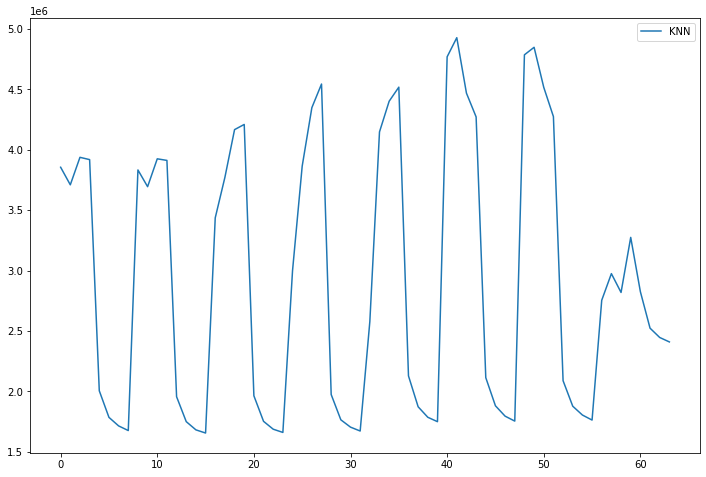

In [70]:
plt.figure(figsize=(12, 8))
plt.plot(knn_list, label='KNN')
plt.legend()
plt.show()

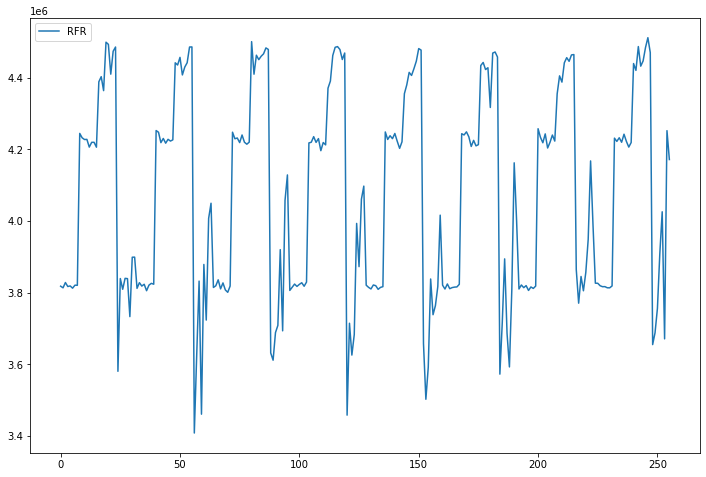

In [71]:
plt.figure(figsize=(12, 8))
plt.plot(rfr_list, label='RFR')
plt.legend()
plt.show()

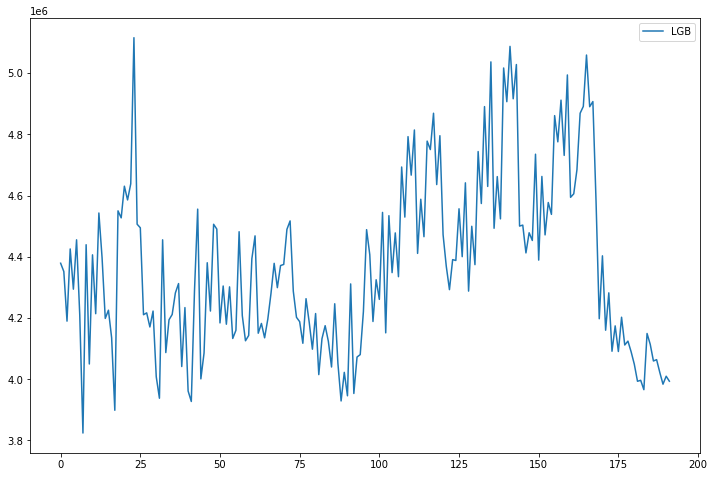

In [72]:
plt.figure(figsize=(12, 8))
plt.plot(lgb_list, label='LGB')
plt.legend()
plt.show()

## 최종 모델 선정 및 학습

### 최종 모델 학습

In [77]:
def pipeline(X):
    X[biased_variables] = X[biased_variables] - X[biased_variables].min() + 1
    X[biased_variables] = np.sqrt(X[biased_variables])        
    X = pd.DataFrame(scaler.transform(X), columns = X.columns)
    X = X[best_features]
    return X
    
model = best_model(**best_parameter).fit(pipeline(X).values, Y)

### 적용 데이터 구성
- submission_df에 대해서도 같은 적용을 하도록 전처리 과정을 똑같이 반복

In [78]:
# 월 추가 : 2019-03-01 ~ 2019-05-31
submission_df['t'] = (2019 - 2016) * 12 + 2

In [79]:
# region 변수와 type_of_business 변수 추가
submission_df['region'] = submission_df['store_id'].replace(store_to_region)
submission_df['type_of_business'] = submission_df['store_id'].replace(store_to_type_of_business)

#### 특징 추가

In [80]:
submission_df['평균할부율'] = submission_df['store_id'].replace(installment_term_per_store.to_dict())
submission_df.head()

,store_id,amount,t,region,type_of_business,평균할부율
0,0,0,38,없음,기타 미용업,0.038384
1,1,0,38,없음,없음,0.000000
2,2,0,38,없음,없음,0.083904
3,4,0,38,서울 종로구,없음,0.001201
4,5,0,38,없음,의복 액세서리 및 모조 장신구 도매업,0.075077


In [81]:
submission_df.drop('amount', axis = 1, inplace = True)

In [82]:
# 1, 2, 3개월 이전 매출에 대한 변수 추가 : t - k (k = 1, 2, 3) 시점의 추가
# submission_df의 t는 amount_sum_per_t_and_sid의 t-k과 부착되어야 하므로, amount_sum_per_t_and_sid의 t에 k를 더함

for k in range(1, 4):
    amount_sum_per_t_and_sid['t_{}'.format(k)] = amount_sum_per_t_and_sid['t'] + k    
    submission_df = pd.merge(submission_df, amount_sum_per_t_and_sid.drop('t', axis = 1), left_on = ['store_id', 't'], right_on = ['store_id', 't_{}'.format(k)])
    submission_df.rename({"amount":"{}_before_amount".format(k)}, axis = 1, inplace = True)
    submission_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_sum_per_t_and_sid.drop(['t_{}'.format(k)], axis = 1, inplace = True)

In [83]:
# 지역 관련 변수 추가 : t - k (k = 1, 2, 3) 시점의 추가
for k in range(1, 4):
    amount_mean_per_t_and_region['t_{}'.format(k)] = amount_mean_per_t_and_region['t'] + k
    submission_df = pd.merge(submission_df, amount_mean_per_t_and_region.drop('t', axis = 1), left_on = ['region', 't'], right_on = ['region', 't_{}'.format(k)])
    submission_df.rename({"amount":"{}_before_amount_of_region".format(k)}, axis = 1, inplace = True)
    
    submission_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_mean_per_t_and_region.drop(['t_{}'.format(k)], axis = 1, inplace = True)    

In [84]:
# 업종 관련 변수 추가:  t - k (k = 1, 2, 3) 시점의 추가

for k in range(1, 4):
    amount_mean_per_t_and_type_of_business['t_{}'.format(k)] = amount_mean_per_t_and_type_of_business['t'] + k
    submission_df = pd.merge(submission_df, amount_mean_per_t_and_type_of_business.drop('t', axis = 1), left_on = ['type_of_business', 't'], right_on = ['type_of_business', 't_{}'.format(k)])
    submission_df.rename({"amount":"{}_before_amount_of_type_of_business".format(k)}, axis = 1, inplace = True)
    
    submission_df.drop(['t_{}'.format(k)], axis = 1, inplace = True)
    amount_mean_per_t_and_type_of_business.drop(['t_{}'.format(k)], axis = 1, inplace = True)       
    
submission_df.head()

,store_id,t,region,type_of_business,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,38,없음,기타 미용업,0.038384,682857.142857,874571.428571,676000.000000,9.468777e+05,1.000725e+06,9.886195e+05,585125.0,650055.952381,558241.666667
1,792,38,없음,기타 미용업,0.218887,743214.285714,871071.428571,973857.142857,9.468777e+05,1.000725e+06,9.886195e+05,585125.0,650055.952381,558241.666667
2,1828,38,경기 용인시,기타 미용업,0.195502,953000.000000,816857.142857,911957.142857,1.801051e+06,2.009936e+06,1.897275e+06,585125.0,650055.952381,558241.666667
3,23,38,경기 안양시,기타 미용업,0.048795,660857.142857,999285.714286,827571.428571,7.843780e+05,6.421832e+05,6.788446e+05,585125.0,650055.952381,558241.666667
4,192,38,경기 화성시,기타 미용업,0.100542,467571.428571,550571.428571,399142.857143,1.209348e+06,1.125181e+06,1.049587e+06,585125.0,650055.952381,558241.666667


#### 최종 모델로 결과 도출

In [85]:
submission_X = submission_df[X.columns]
submission_X = pipeline(submission_X)

pred_Y = model.predict(submission_X)

result = pd.DataFrame({"store_id":submission_df['store_id'].values,
                      "pred_amount":pred_Y})

C:\Users\baebi\AppData\Local\Temp\ipykernel_24520\1546412556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[biased_variables] = X[biased_variables] - X[biased_variables].min() + 1
C:\Users\baebi\AppData\Local\Temp\ipykernel_24520\1546412556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[biased_variables] = np.sqrt(X[biased_variables])
c:\Users\baebi\miniconda3\envs\ds_study\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsRegressor was fitted without featu

In [87]:
result.sort_values(by='store_id', inplace=True)

result

,store_id,pred_amount
0,0,4.714476e+06
12,1,1.315465e+06
13,2,1.564663e+06
612,4,6.729287e+06
1187,5,3.723537e+06
...,...,...
609,2132,2.768582e+06
610,2133,1.326843e+06
1186,2134,2.159169e+06
611,2135,2.164861e+06
